In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis_sol
import matplotlib.pyplot as plt
import cupy as cp
importlib.reload(kgs)
#pack_vis.plot_polygons([kgs.center_tree] + kgs.convex_breakdown)

local
local


<module 'kaggle_support' from '/mnt/d/packing/code/analysis/../core/kaggle_support.py'>

<Axes: >

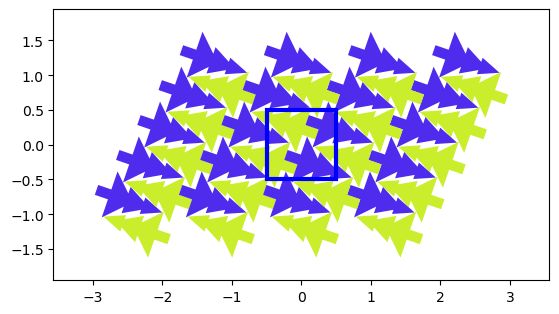

In [17]:
sol = kgs.create_tiled_solution('Perfect dimer', 5, make_symmetric=True, axis1_offset=0.5)
#sol.rotate(cp.array([[cp.pi/3.5]]))
#sol.xyt+= cp.array([[0.0, 0.1, 0.0]])
pack_vis_sol.pack_vis_sol(sol.convert_to_phenotype())